Authors: Varvara Vetrova, Sheldon Coup (Msc)

The following part is just additional libraries and functions that we neeed

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

**NOTE : In order to run this notebook quickly we will need to enable GPU acceleration.**

**In the top menu go to Edit -> Notebook Settings -> Hardware Acceleration and click on GPU**

If you do not do this, training of the neural networks will take **much** longer .

As we seen, fully connected neural networks are powerful tools for vectorized data. By converting images to vectors, we can use fully connected networks to classify images, as we did with MNIST. However, when we have larger images and colour images, the number of parameters quickly gets out of hand.

Lets download the Cifar10 dataset and have a look at it. \
[More information on Cifar10](https://www.cs.toronto.edu/~kriz/cifar.html)

In [3]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()


# converting the data type and scaling between 0 and 1
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

170508288/170498071 [==============================] - 2s 0us/step


Lets have a look at the dimensions of the cifar images and check out the first image in the dataset.

Training data shape:  (50000, 32, 32, 3)
Test data shape (10000, 32, 32, 3)
Training response shape:,  (50000, 1)
Testing response shape:  (10000, 1)
(32, 32, 3)


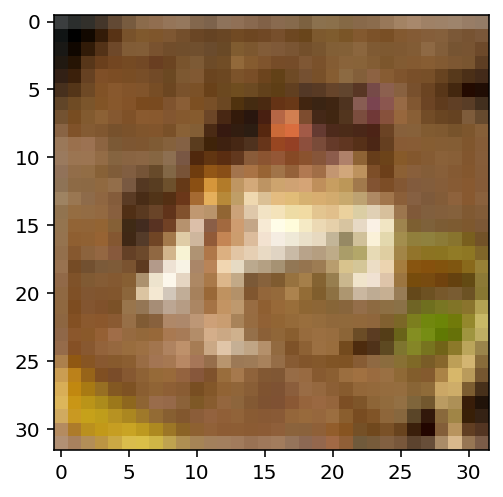

In [4]:
print("Training data shape: ", x_train.shape) # (60000, 28, 28) -- 60000 images, each 28x28 pixels
print("Test data shape", x_test.shape) # (10000, 28, 28) -- 10000 images, each 28x28
print("Training response shape:, ", y_train.shape)
print("Testing response shape: ", y_test.shape)

image_size = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
print(image_size)

plt.imshow(x_train[0])

From this we can see that we have images that are 32 * 32 * 3. This means we have a 32 * 32 image with 3 different colour channels (RGB).
If we convert this to a vector we will have a vector of length 32 * 32 * 3 = 3072, which is significanlty larger than what we had to deal with for MNIST. 

Let's reshape (flatten) these arrays. The images will be converted to vectors. However, unlike last time, we aren't going to overwrite the x_train and x_test objects, we will keep them around for later.


In [5]:
# Flatten the images
image_vector_size = image_size[0] * image_size[1] * image_size[2]


x_train_vector = x_train.reshape(x_train.shape[0], image_vector_size)

x_test_vector = x_test.reshape(x_test.shape[0], image_vector_size)

print(x_train_vector.shape)

(50000, 3072)


Before moving onto building the network we need to convert the labels into one-hot-encoded target labels. Like last time we are using the to_categorical function to do this.


In [6]:
print("First 5 training labels: ", y_train[:5]) 

# Convert to "one-hot" vectors using the to_categorical function
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print("First 5 training lables as one-hot encoded vectors:\n", y_train[:5])
print(y_train.shape)

First 5 training labels:  [[6]
 [9]
 [9]
 [4]
 [1]]
First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
(50000, 10)


Lets build a simple fully connected model similar to last week, but with two hidden layers this time.

In [7]:
def build_basic_model():
  model = Sequential()

  # The input layer requires the special input_shape parameter which should match
  # the shape of our training data.
  model.add(Dense(units=1024, activation='sigmoid', input_shape=(image_vector_size,)))
  model.add(Dense(units=256, activation='sigmoid'))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model
model = build_basic_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              3146752   
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 3,411,722
Trainable params: 3,411,722
Non-trainable params: 0
_________________________________________________________________


With nearly 3.5 million parameters to learn, our model is much bigger than last time.
Let's compile the model with an ADAM optimizer.

In [8]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Learning from the last lab, we will train for 50 epochs the first time around.

In [9]:
history = model.fit(x_train_vector, y_train, batch_size=512, epochs=50, verbose=True, validation_split=.1)
loss, accuracy  = model.evaluate(x_test_vector, y_test, verbose=False)

Epoch 1/50
88/88 [==============================] - 5s 21ms/step - loss: 2.0078 - accuracy: 0.2714 - val_loss: 1.8386 - val_accuracy: 0.3402
Epoch 2/50
88/88 [==============================] - 1s 13ms/step - loss: 1.7733 - accuracy: 0.3687 - val_loss: 1.7701 - val_accuracy: 0.3566
Epoch 3/50
88/88 [==============================] - 1s 13ms/step - loss: 1.6758 - accuracy: 0.4022 - val_loss: 1.6550 - val_accuracy: 0.4162
Epoch 4/50
88/88 [==============================] - 1s 13ms/step - loss: 1.6099 - accuracy: 0.4263 - val_loss: 1.6149 - val_accuracy: 0.4308
Epoch 5/50
88/88 [==============================] - 1s 13ms/step - loss: 1.5671 - accuracy: 0.4435 - val_loss: 1.6446 - val_accuracy: 0.4168
Epoch 6/50
88/88 [==============================] - 1s 13ms/step - loss: 1.5168 - accuracy: 0.4627 - val_loss: 1.5477 - val_accuracy: 0.4506
Epoch 7/50
88/88 [==============================] - 1s 14ms/step - loss: 1.4853 - accuracy: 0.4750 - val_loss: 1.5285 - val_accuracy: 0.4534
Epoch 8/50
88

That seems to be learning well, lets have a look at the loss /accuracy curves.

Test loss: 1.5
Test accuracy: 0.524


<Figure size 576x432 with 0 Axes>

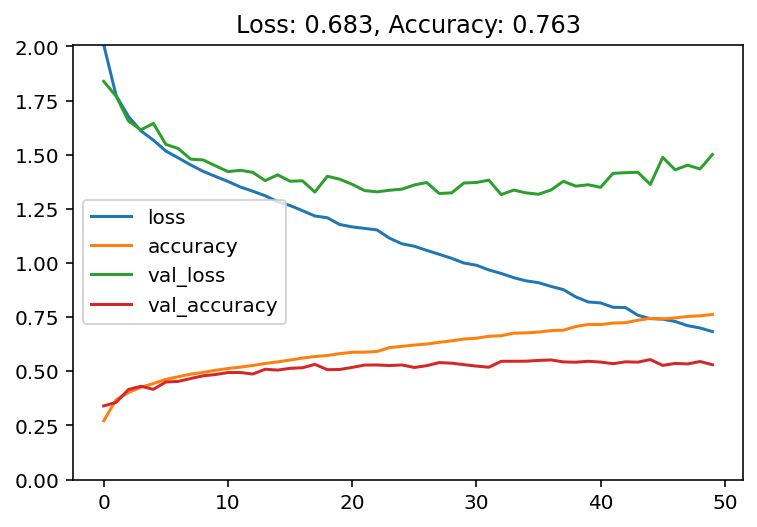

In [10]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In the early stage of training all is going well, but the model is not generalizing well towards the end! This can be seen by the widening gap between the validation and training loss and accuracy lines. This is a sign that the network is *overfitting*.

This overfitting may be related to the fact that we have over 3.5 million parameters in our model. Imagine if we had a larger input image, the number of parameters would explode!
If we had a 300 * 300 RGB image then we would have over 300 million parameters for our little 2 layer network. 

Finally, our vectorized data and the fully connected model doesn't take into account any of the spatial relationships in the image, as its just jumbles all the pixels around into a single vector.



For these reasons we would like to move on to a *Convolutional Neural Network*.

Let's write a function to put together a convolutional neural network. We will be using a new layer called **Conv2D**.\
The Conv2D layer takes in the following arguments:


1.   Number  of filters, this is similar to setting the number of neurons in a Dense layer. Must be an integer.
2.   Filter size, , the dimension of each filter being used. Tuple of integers
3.   Activation, same sort of functions as we used for Dense layers.
4.   Padding, this determines if the model adds extra rows /columns to the input. This gives control over the shape of the output. For more details refer to the lecture slides, Lecture 14 on Learn.


More information on convolutional layers can be found [here](https://keras.io/layers/convolutional/).

One thing to note about convolutional neural networks is that they still normally have the Dense layers in the end like a usual fully-connected network.

Below is a function that puts together a simple convolutional network:



In [11]:
def build_convnet():
  model = Sequential()
  
  model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape = image_size))
  model.add(Conv2D(32, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))

  model.add(Conv2D(64, (3, 3), activation='relu'))

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))

  model.add(Dense(num_classes, activation='softmax'))
  
 
  return model
model = build_convnet()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                  

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

**Reminder: If you have not enabled GPU hardware acceleration yet then training this convnet will take much longer!!!.**

In [14]:
history = model.fit(x_train, y_train, batch_size=256, epochs=50, verbose=True, validation_split=.1, shuffle=True)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

Epoch 1/50
176/176 [==============================] - 16s 44ms/step - loss: 1.9259 - accuracy: 0.3140 - val_loss: 1.6590 - val_accuracy: 0.4126
Epoch 2/50
176/176 [==============================] - 7s 38ms/step - loss: 1.5603 - accuracy: 0.4496 - val_loss: 1.4639 - val_accuracy: 0.4698
Epoch 3/50
176/176 [==============================] - 7s 38ms/step - loss: 1.4183 - accuracy: 0.4983 - val_loss: 1.3474 - val_accuracy: 0.5206
Epoch 4/50
176/176 [==============================] - 7s 38ms/step - loss: 1.3190 - accuracy: 0.5349 - val_loss: 1.2659 - val_accuracy: 0.5530
Epoch 5/50
176/176 [==============================] - 7s 38ms/step - loss: 1.2538 - accuracy: 0.5589 - val_loss: 1.2253 - val_accuracy: 0.5684
Epoch 6/50
176/176 [==============================] - 7s 39ms/step - loss: 1.1921 - accuracy: 0.5824 - val_loss: 1.1818 - val_accuracy: 0.5882
Epoch 7/50
176/176 [==============================] - 7s 38ms/step - loss: 1.1473 - accuracy: 0.6021 - val_loss: 1.1526 - val_accuracy: 0.600

Test loss: 1.22
Test accuracy: 0.674


<Figure size 576x432 with 0 Axes>

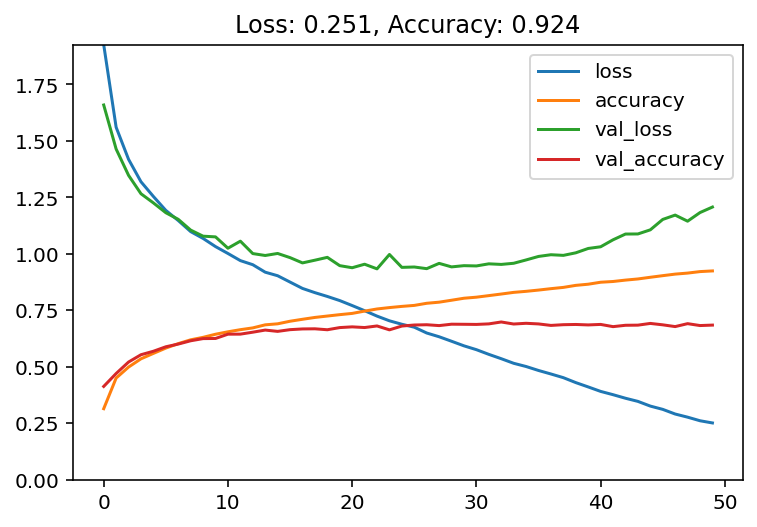

In [15]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

We can see here that the model is doing better than the fully connected one  but it started to overfit again towards the end. 
Let's add some Dropout layers to try and combat this.


In [ ]:
def build_dropout_convnet():
  model = Sequential()
  
  model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape = image_size))
  model.add(Conv2D(32, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Dropout(0.5))

  model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))

  model.add(Conv2D(64, (3, 3), activation='relu'))

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))

  model.add(Dropout(0.5))
  
  model.add(Dense(num_classes, activation='softmax'))
  
 
  return model
model = build_dropout_convnet()
model.summary()

Lets compile and train the model for the same number of epochs as before.

**Please note that if you would like to train the same model again you need to also compile it again. If you just call model.fit function your weights will be initiliased from the last time you trained that model!!!**

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train.astype('float32'), y_train, batch_size=512, epochs=50, verbose=True, validation_split=.1, shuffle=True)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

Epoch 1/50
88/88 [==============================] - 9s 83ms/step - loss: 2.1689 - accuracy: 0.1781 - val_loss: 1.9946 - val_accuracy: 0.2642
Epoch 2/50
88/88 [==============================] - 6s 70ms/step - loss: 1.8862 - accuracy: 0.3115 - val_loss: 1.7695 - val_accuracy: 0.3606
Epoch 3/50
88/88 [==============================] - 6s 70ms/step - loss: 1.7229 - accuracy: 0.3744 - val_loss: 1.6266 - val_accuracy: 0.4060
Epoch 4/50
88/88 [==============================] - 6s 71ms/step - loss: 1.6431 - accuracy: 0.3989 - val_loss: 1.5570 - val_accuracy: 0.4304
Epoch 5/50
88/88 [==============================] - 6s 70ms/step - loss: 1.5871 - accuracy: 0.4188 - val_loss: 1.5239 - val_accuracy: 0.4498
Epoch 6/50
88/88 [==============================] - 6s 71ms/step - loss: 1.5414 - accuracy: 0.4349 - val_loss: 1.4520 - val_accuracy: 0.4766
Epoch 7/50
88/88 [==============================] - 6s 71ms/step - loss: 1.4987 - accuracy: 0.4520 - val_loss: 1.4203 - val_accuracy: 0.4900
Epoch 8/50
88

Hopefully, thats a bit better, lets have a look at the loss / accuracy curves and check the test accuracy.

Test loss: 0.857
Test accuracy: 0.701


<Figure size 576x432 with 0 Axes>

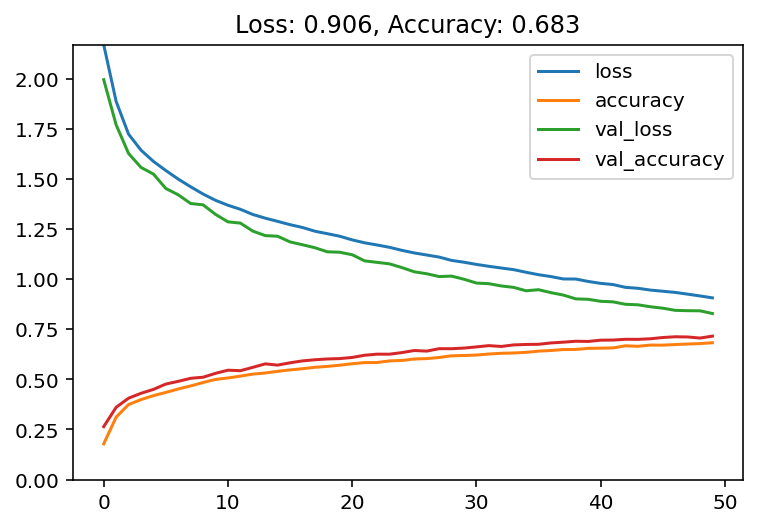

In [19]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Great! The convolutional model works. Clearly 50 epochs isn't quite enough, but we can see how much the dropout layers have improved the generalization performance of the model.

However, to help us get an idea of whats actually going on lets look at how the layers respond to a particular image. In other words, let's look at **feature maps**!

First, let's look at an image that we are going to use. Feel free to change this index to whatever number you like, so you can see how it works with different images.

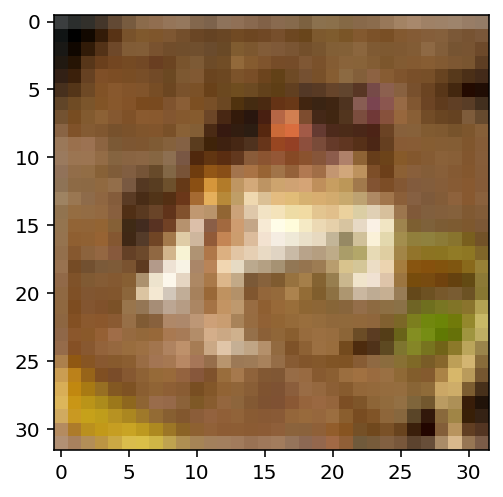

In [20]:
demo_image_index = 0

plt.imshow(x_train[demo_image_index])

Lets see how one of the first filters is responding to this image. If we plot single layer of this feature map we can see that is will be picking up specific features of the input image.

(1, 32, 32, 32)


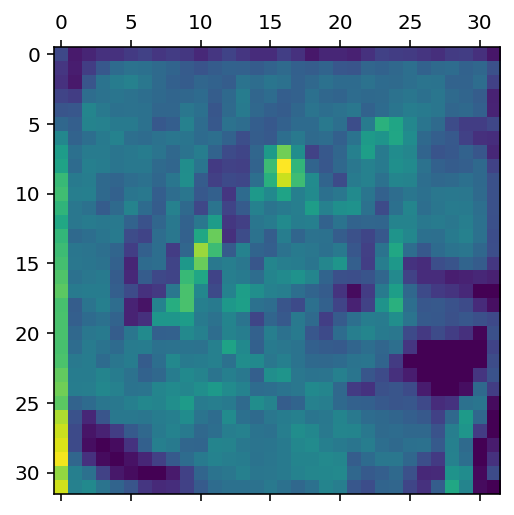

In [21]:
layer_outputs = [layer.output for layer in model.layers[:8]] 
# Extracts the outputs of the top 12 layers

activation_model = Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(np.expand_dims(x_train[demo_image_index], axis=0))
first_layer_activation = activations[0]
print(first_layer_activation.shape)

#change this index and re-run this cell to have a look at different layers, see if you can figure out what the layers are responding
demo_filter_index = 2

plt.matshow(first_layer_activation[0, :, :, demo_filter_index], cmap='viridis')

Lets plot all the activation maps, don't worry about how the code works in this section, it is just for demonstration.

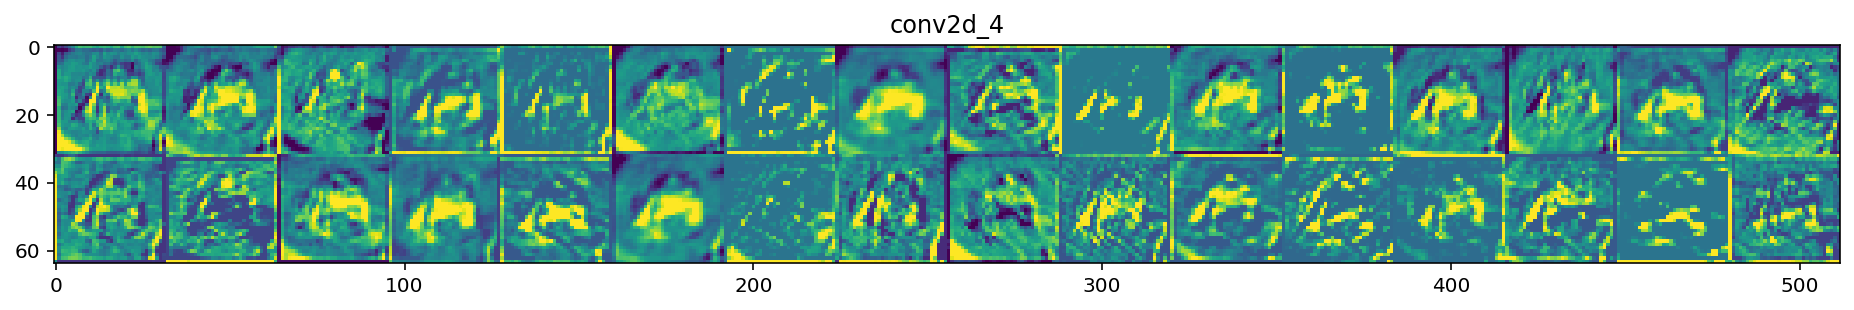

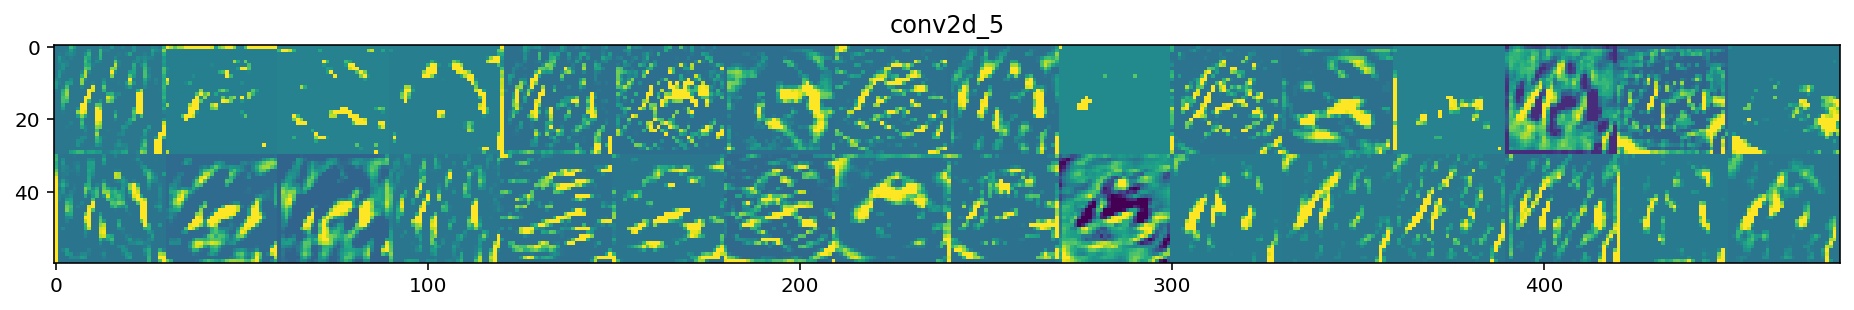

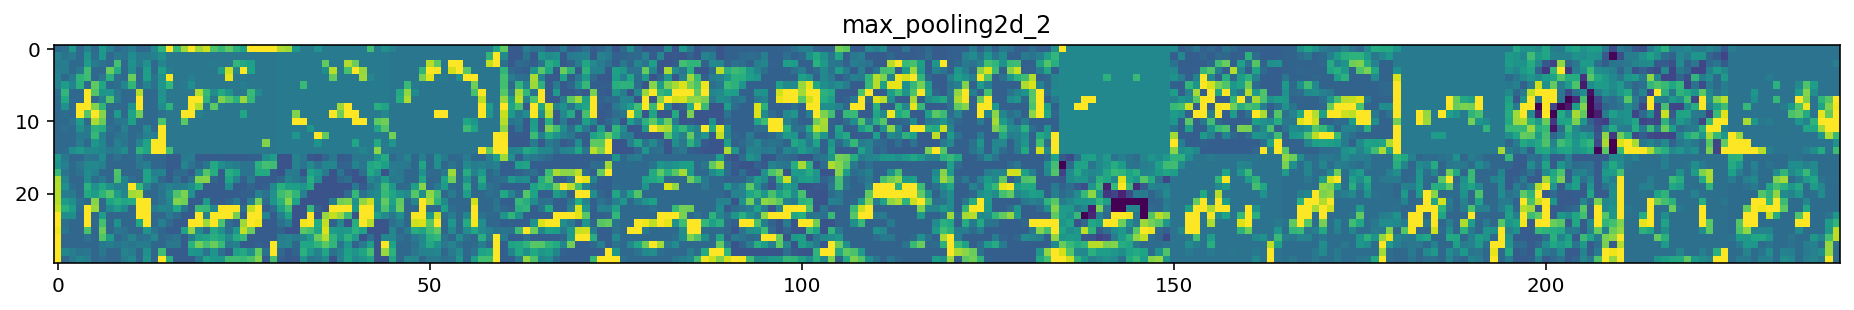

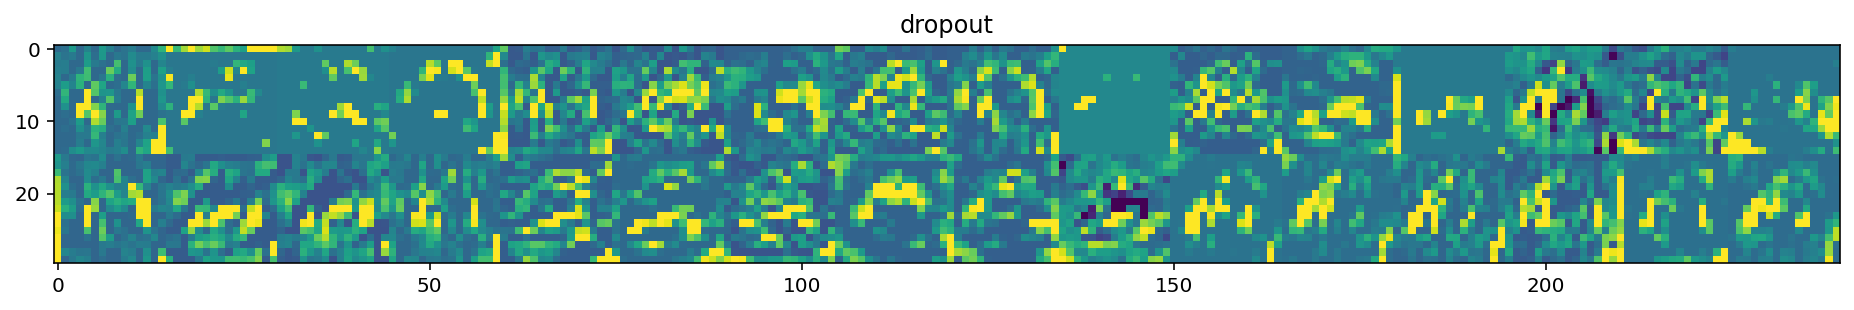

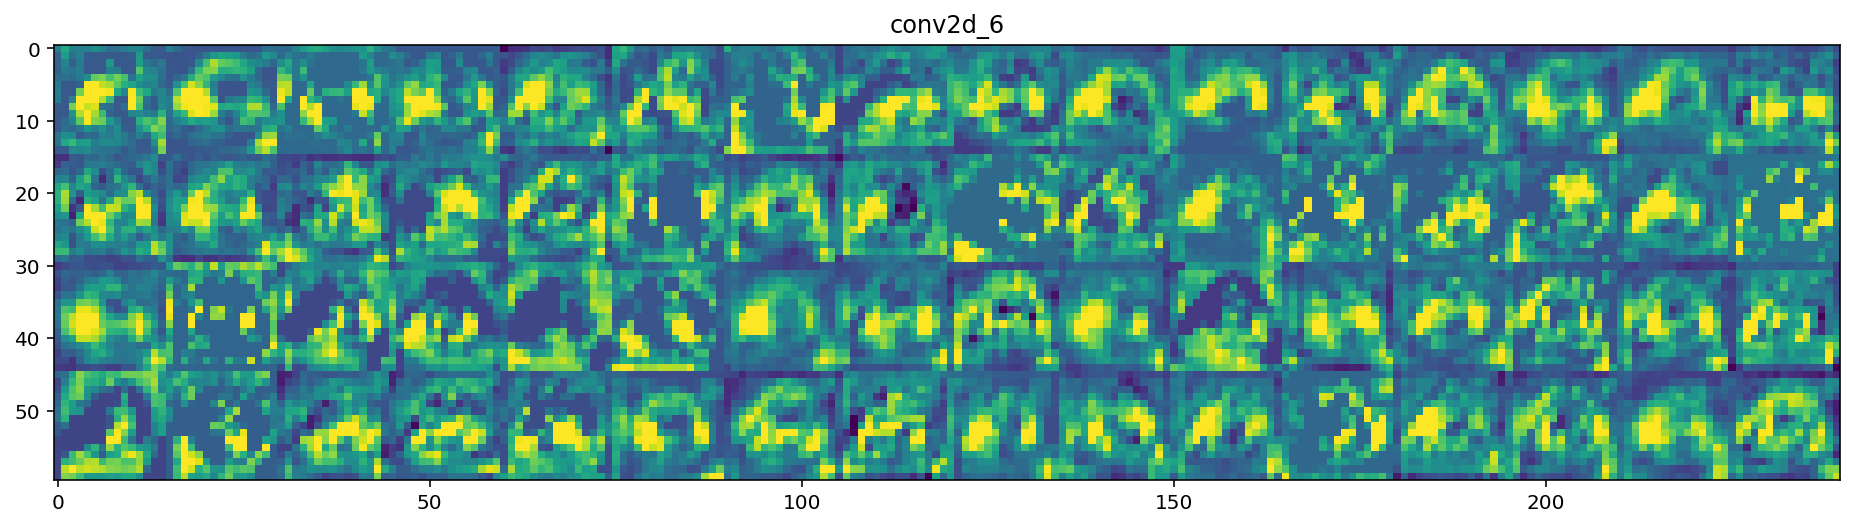

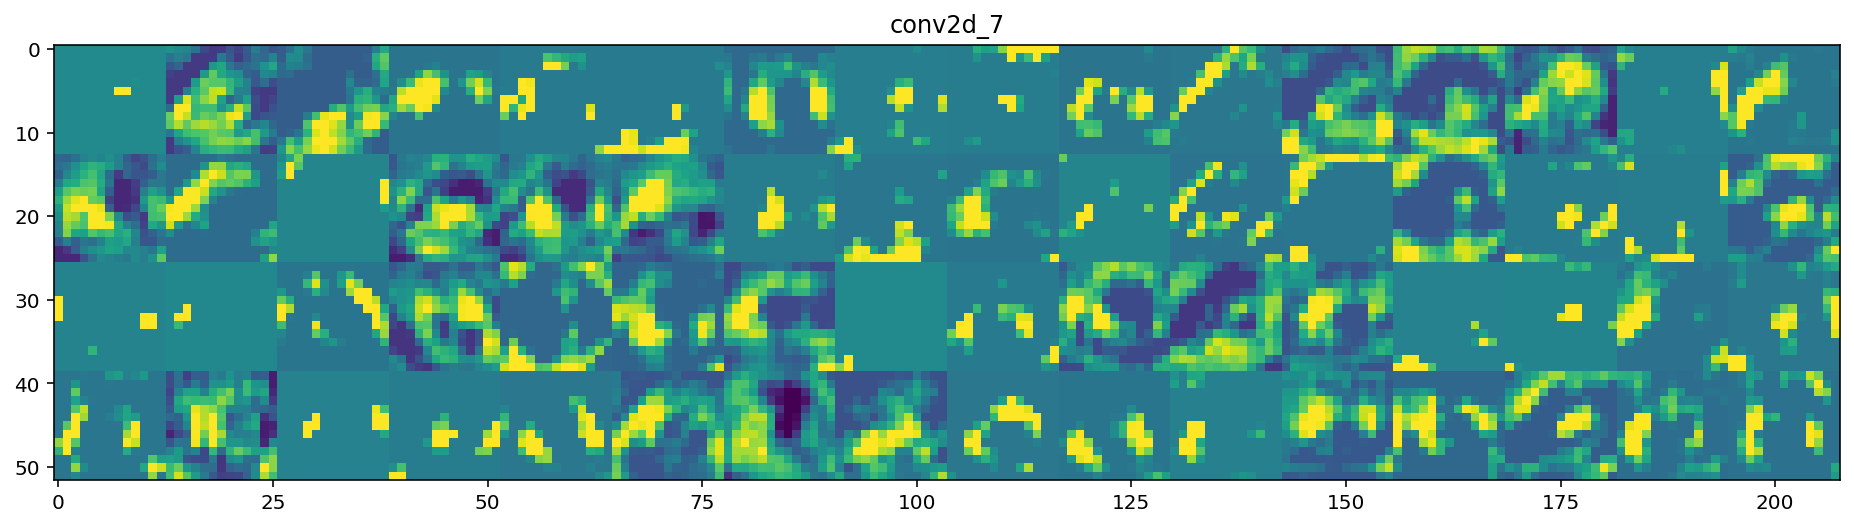

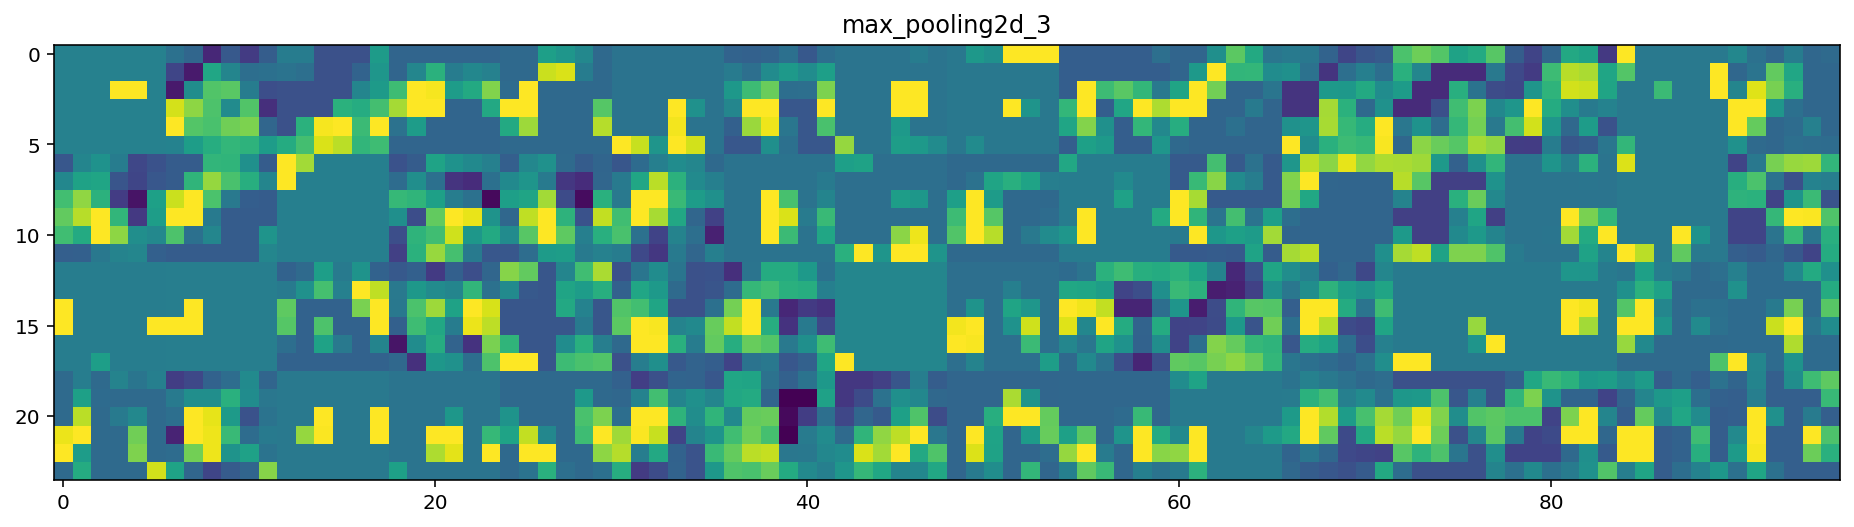

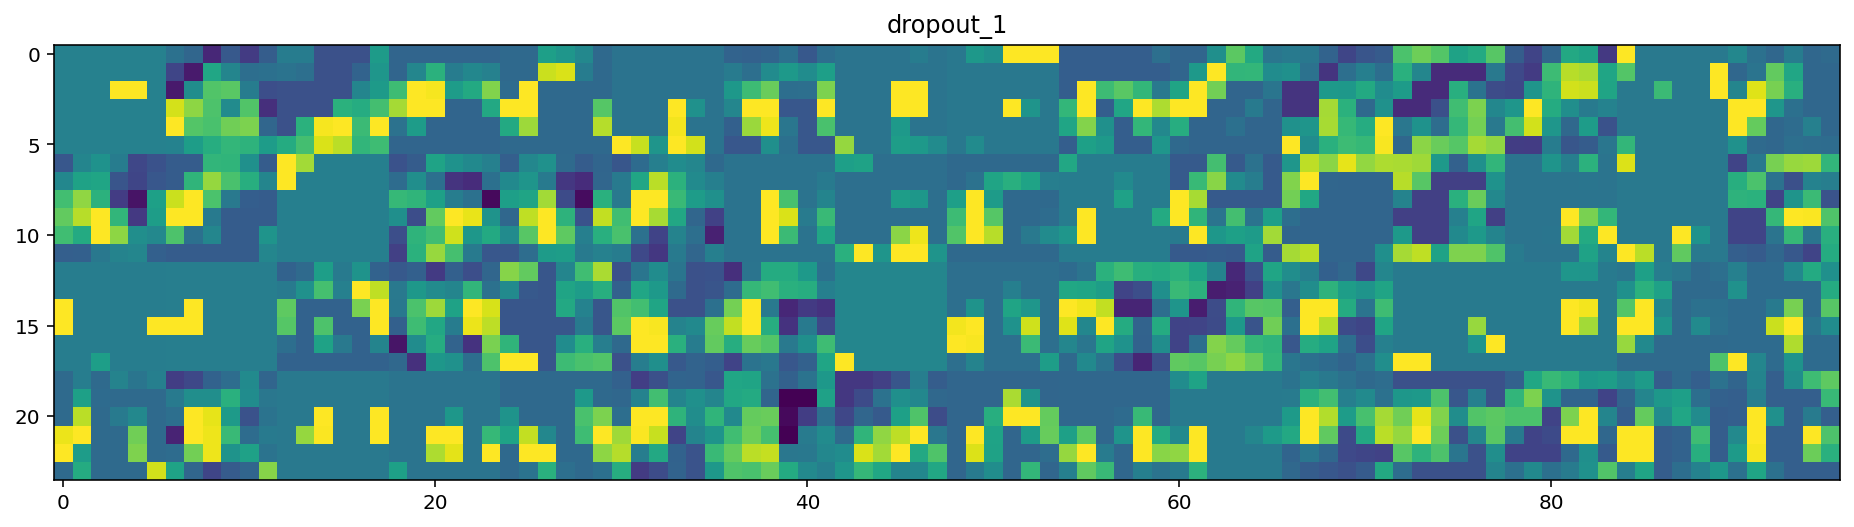

In [22]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')


**Feel free to experiment with this network, try to change settings, observe how it effects the perfomance**